In [217]:
## importing neccesary libraries  
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns  
import yfinance as yf  
import numpy as np 
from statsmodels.tsa.seasonal import seasonal_decompose,STL
sns.set(rc={"axes.facecolor":"#DAF3F2","axes.grid":False})
from scipy.stats import ks_2samp
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
np.random.seed(0)
from statsmodels.distributions.empirical_distribution import ECDF
import warnings
warnings.filterwarnings("ignore")

#### **Loading the data**

In [218]:
## Loading the data  
def stock(ticker):  
    return yf.download(ticker,period="10y")
apple_data = stock("AAPL")

[*********************100%***********************]  1 of 1 completed


In [219]:
## displaying the data  
apple_data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-04-27,29.624418,29.731618,29.289427,29.548488,387816800
2015-04-28,29.157663,30.046507,28.936571,30.028643,475696000
2015-04-29,28.728870,29.387686,28.652940,29.068329,253544400
2015-04-30,27.949455,28.728868,27.822159,28.728868,332781600
2015-05-01,28.798103,29.061632,27.982959,28.161620,234050400


In [220]:
## checking the index of the timeseries data  
apple_data.index

DatetimeIndex(['2015-04-27', '2015-04-28', '2015-04-29', '2015-04-30',
               '2015-05-01', '2015-05-04', '2015-05-05', '2015-05-06',
               '2015-05-07', '2015-05-08',
               ...
               '2025-04-11', '2025-04-14', '2025-04-15', '2025-04-16',
               '2025-04-17', '2025-04-21', '2025-04-22', '2025-04-23',
               '2025-04-24', '2025-04-25'],
              dtype='datetime64[ns]', name='Date', length=2516, freq=None)

In [221]:
## changing the dateime obhect to a Monthly periodicity  
apple_data.index = pd.to_datetime(apple_data.index).to_period(freq='B')
## checking the index again 
apple_data.index

PeriodIndex(['2015-04-27', '2015-04-28', '2015-04-29', '2015-04-30',
             '2015-05-01', '2015-05-04', '2015-05-05', '2015-05-06',
             '2015-05-07', '2015-05-08',
             ...
             '2025-04-11', '2025-04-14', '2025-04-15', '2025-04-16',
             '2025-04-17', '2025-04-21', '2025-04-22', '2025-04-23',
             '2025-04-24', '2025-04-25'],
            dtype='period[B]', name='Date', length=2516)

In [222]:
## getting the close data  
close_data = apple_data['Close'][['AAPL']]
## showing the data 
close_data.head()

Ticker,AAPL
Date,
2015-04-27,29.624418
2015-04-28,29.157663
2015-04-29,28.728870
2015-04-30,27.949455
2015-05-01,28.798103


In [223]:
## checking the index 
close_data.index

PeriodIndex(['2015-04-27', '2015-04-28', '2015-04-29', '2015-04-30',
             '2015-05-01', '2015-05-04', '2015-05-05', '2015-05-06',
             '2015-05-07', '2015-05-08',
             ...
             '2025-04-11', '2025-04-14', '2025-04-15', '2025-04-16',
             '2025-04-17', '2025-04-21', '2025-04-22', '2025-04-23',
             '2025-04-24', '2025-04-25'],
            dtype='period[B]', name='Date', length=2516)

In [224]:
## creating a time series index object   
idx = pd.period_range(min(close_data.index),max(close_data.index))
idx

PeriodIndex(['2015-04-27', '2015-04-28', '2015-04-29', '2015-04-30',
             '2015-05-01', '2015-05-04', '2015-05-05', '2015-05-06',
             '2015-05-07', '2015-05-08',
             ...
             '2025-04-14', '2025-04-15', '2025-04-16', '2025-04-17',
             '2025-04-18', '2025-04-21', '2025-04-22', '2025-04-23',
             '2025-04-24', '2025-04-25'],
            dtype='period[B]', length=2610)

In [225]:
## days when the market was closed  
close_data.index.symmetric_difference(idx)

PeriodIndex(['2015-05-25', '2015-07-03', '2015-09-07', '2015-11-26',
             '2015-12-25', '2016-01-01', '2016-01-18', '2016-02-15',
             '2016-03-25', '2016-05-30', '2016-07-04', '2016-09-05',
             '2016-11-24', '2016-12-26', '2017-01-02', '2017-01-16',
             '2017-02-20', '2017-04-14', '2017-05-29', '2017-07-04',
             '2017-09-04', '2017-11-23', '2017-12-25', '2018-01-01',
             '2018-01-15', '2018-02-19', '2018-03-30', '2018-05-28',
             '2018-07-04', '2018-09-03', '2018-11-22', '2018-12-05',
             '2018-12-25', '2019-01-01', '2019-01-21', '2019-02-18',
             '2019-04-19', '2019-05-27', '2019-07-04', '2019-09-02',
             '2019-11-28', '2019-12-25', '2020-01-01', '2020-01-20',
             '2020-02-17', '2020-04-10', '2020-05-25', '2020-07-03',
             '2020-09-07', '2020-11-26', '2020-12-25', '2021-01-01',
             '2021-01-18', '2021-02-15', '2021-04-02', '2021-05-31',
             '2021-07-05', '2021-0

In [226]:
## reindexing  
close_data = close_data.reindex(idx,fill_value=np.nan)
close_data.tail()

Ticker,AAPL
2025-04-21,193.160004
2025-04-22,199.740005
2025-04-23,204.600006
2025-04-24,208.369995
2025-04-25,209.279999


In [227]:
## forward filling  
close_data = close_data.fillna(method="ffill")
close_data.tail()

Ticker,AAPL
2025-04-21,193.160004
2025-04-22,199.740005
2025-04-23,204.600006
2025-04-24,208.369995
2025-04-25,209.279999


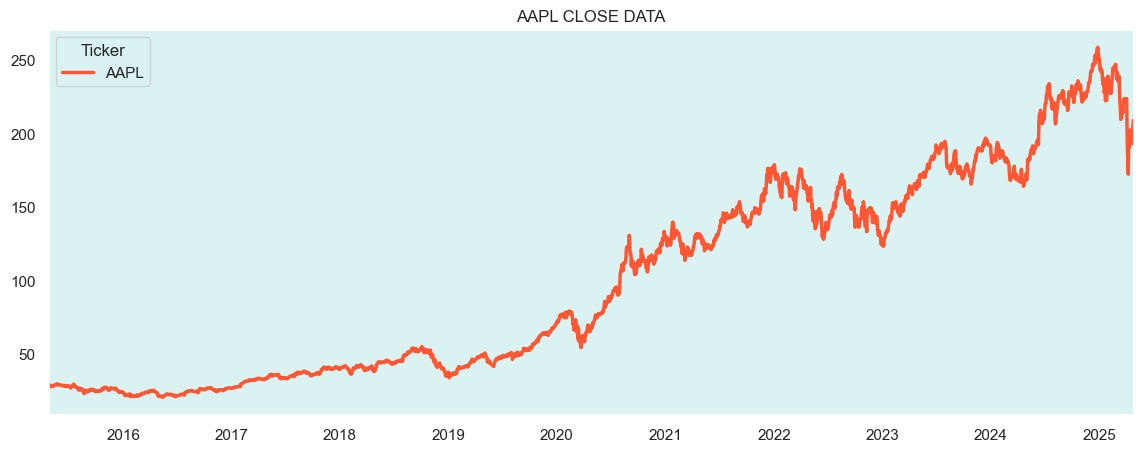

In [228]:
## visualizing the data  
close_data.plot(figsize=(14,5),color="#FF5733",linewidth=2.5)
plt.title("AAPL CLOSE DATA")
plt.show()

In [229]:
close_data.index = close_data.index.to_timestamp()
close_data.index

DatetimeIndex(['2015-04-27', '2015-04-28', '2015-04-29', '2015-04-30',
               '2015-05-01', '2015-05-04', '2015-05-05', '2015-05-06',
               '2015-05-07', '2015-05-08',
               ...
               '2025-04-14', '2025-04-15', '2025-04-16', '2025-04-17',
               '2025-04-18', '2025-04-21', '2025-04-22', '2025-04-23',
               '2025-04-24', '2025-04-25'],
              dtype='datetime64[ns]', length=2610, freq='B')

#### **VISUALIZATIONS**

In [230]:
## checking th data  
close_data.head()

Ticker,AAPL
2015-04-27,29.624418
2015-04-28,29.157663
2015-04-29,28.728870
2015-04-30,27.949455
2015-05-01,28.798103


In [231]:
### index  
close_data.index

DatetimeIndex(['2015-04-27', '2015-04-28', '2015-04-29', '2015-04-30',
               '2015-05-01', '2015-05-04', '2015-05-05', '2015-05-06',
               '2015-05-07', '2015-05-08',
               ...
               '2025-04-14', '2025-04-15', '2025-04-16', '2025-04-17',
               '2025-04-18', '2025-04-21', '2025-04-22', '2025-04-23',
               '2025-04-24', '2025-04-25'],
              dtype='datetime64[ns]', length=2610, freq='B')

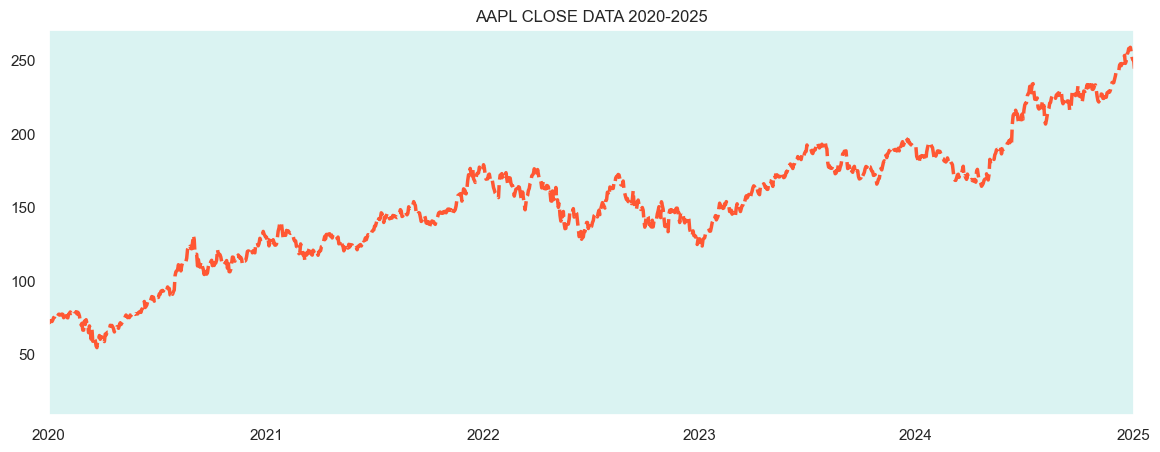

In [232]:
## plot
close_data['AAPL'].plot(figsize=(14,5),color="#FF5733",linewidth=2.5,xlim=(pd.Timestamp("2020-01-01"),pd.Timestamp("2025-01-01")),ls="--")
plt.title("AAPL CLOSE DATA 2020-2025")
plt.show()

### **Resampling**

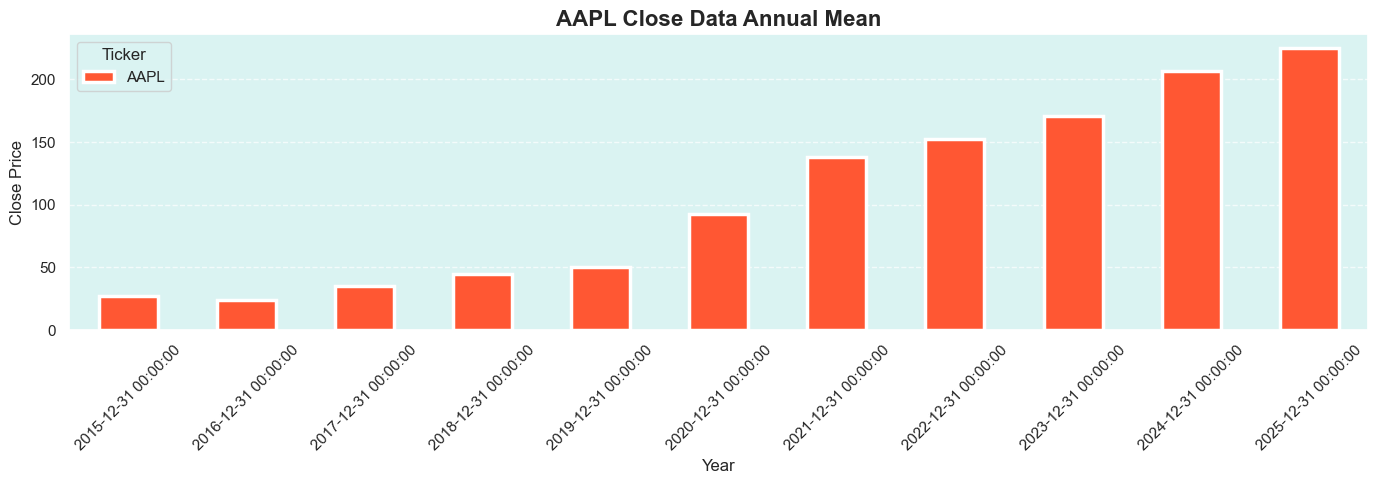

In [233]:

# Resample the data
annual_mean = close_data.resample(rule="YE").mean()
# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 5))
# Plot bar chart
annual_mean.plot(kind="bar", color="#FF5733", linewidth=2.5, ax=ax)
# Plot line chart over the bars
ax.plot(annual_mean.index, annual_mean.values, color="black", marker="o", linestyle="-", linewidth=2)
# Improve title and labels
ax.set_title("AAPL Close Data Annual Mean", fontsize=16, fontweight='bold')
ax.set_ylabel("Close Price", fontsize=12)
ax.set_xlabel("Year", fontsize=12)
plt.xticks(rotation=45)
#  Add grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


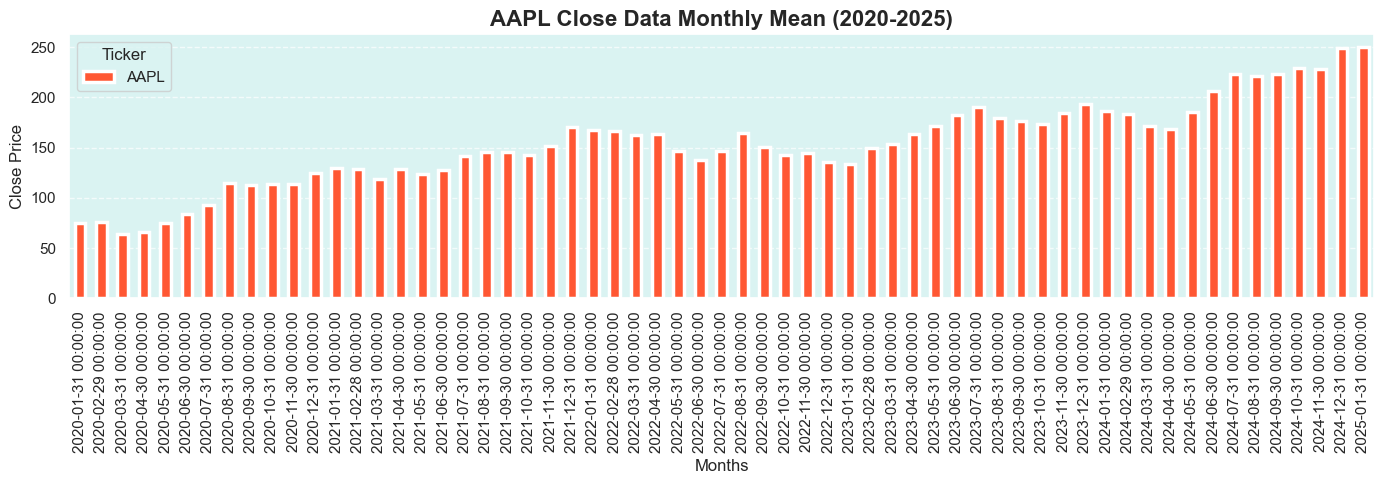

In [234]:
## Monthly resampling from 20202 to 20205
monthly_mean = close_data.loc["2020-01-01":"2025-01-01"].resample(rule="ME").mean()
# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 5))
# Plot bar chart
monthly_mean.plot(kind="bar", color="#FF5733", linewidth=2.5, ax=ax)
# Plot line chart over the bars
ax.plot(monthly_mean.index, monthly_mean.values, color="black", marker="o", linestyle="-", linewidth=2)
# Improve title and labels
ax.set_title("AAPL Close Data Monthly Mean (2020-2025)", fontsize=16, fontweight='bold')
ax.set_ylabel("Close Price", fontsize=12)
ax.set_xlabel("Months", fontsize=12)
plt.xticks(rotation=90)
#  Add grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


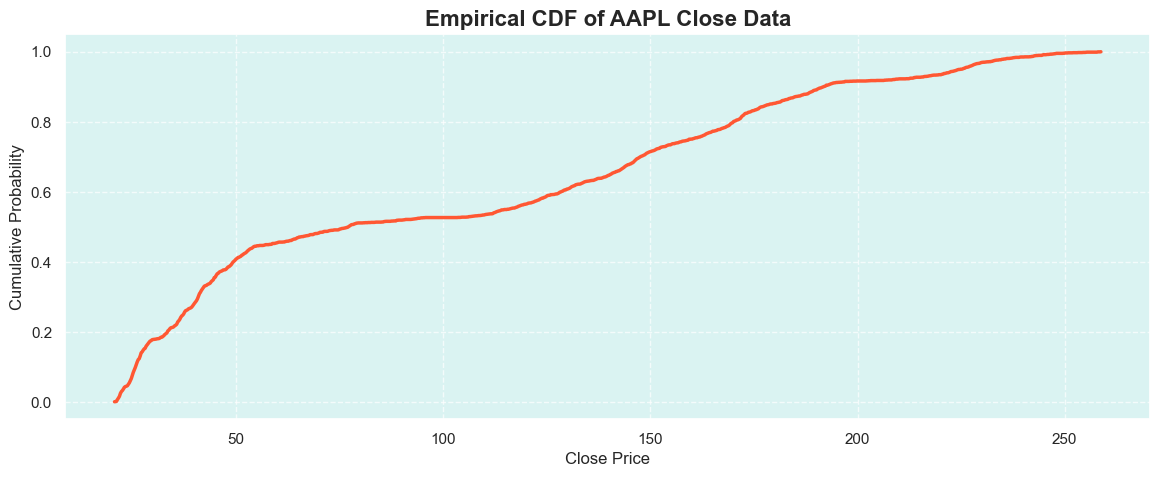

In [235]:
## Empirical CDF of the data
ecdf = ECDF(close_data['AAPL'])
x = np.linspace(close_data['AAPL'].min(), close_data['AAPL'].max(), 1000)
y = ecdf(x)
plt.figure(figsize=(14, 5))
plt.plot(x, y, color="#FF5733", linewidth=2.5)
plt.title("Empirical CDF of AAPL Close Data", fontsize=16, fontweight='bold')
plt.xlabel("Close Price", fontsize=12)
plt.ylabel("Cumulative Probability", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### **CLASSICAL DECOMPOSITION**

In [236]:
from statsmodels.tsa.seasonal import seasonal_decompose ,STL
## specifiying the periodicity  
period_annual= 252
decomp_additive = seasonal_decompose(close_data['AAPL'],model="additive",period=period_annual)

In [237]:
## extracting tthe components  
trend_dditive = decomp_additive.trend 
## seasonal additive  
seasonal_additive = decomp_additive.seasonal 
## residual additve  
residual_additive = decomp_additive.resid

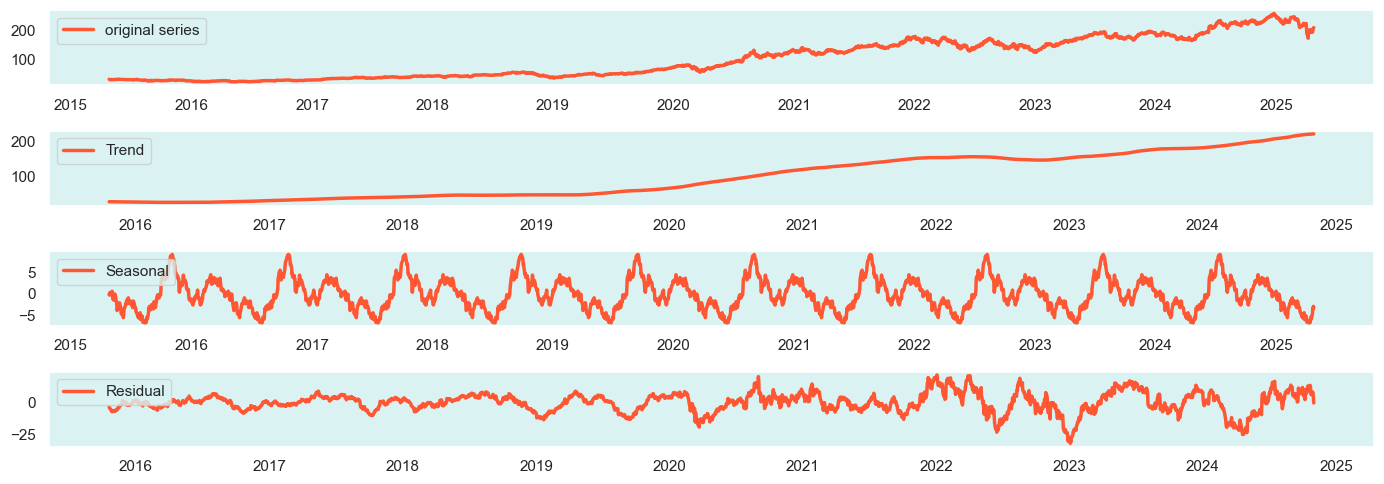

In [238]:
## plotting the plots  
plt.figure(figsize=(14,5))
plt.subplot(4,1,1)
plt.plot(close_data['AAPL'],label="original series",color="#FF5733",linewidth=2.5)
plt.legend(loc='upper left')
plt.subplot(4,1,2)
plt.plot(trend_dditive,label="Trend",color="#FF5733",linewidth=2.5)
plt.legend(loc='upper left')
plt.subplot(4,1,3)
plt.plot(seasonal_additive,label="Seasonal",color="#FF5733",linewidth=2.5)
plt.legend(loc='upper left')
plt.subplot(4,1,4)
plt.plot(residual_additive,label="Residual",color="#FF5733",linewidth=2.5)
plt.legend(loc='upper left')
plt.tight_layout()
plt.subplots_adjust()
plt.show()

### **STL DECOMPOSITION**

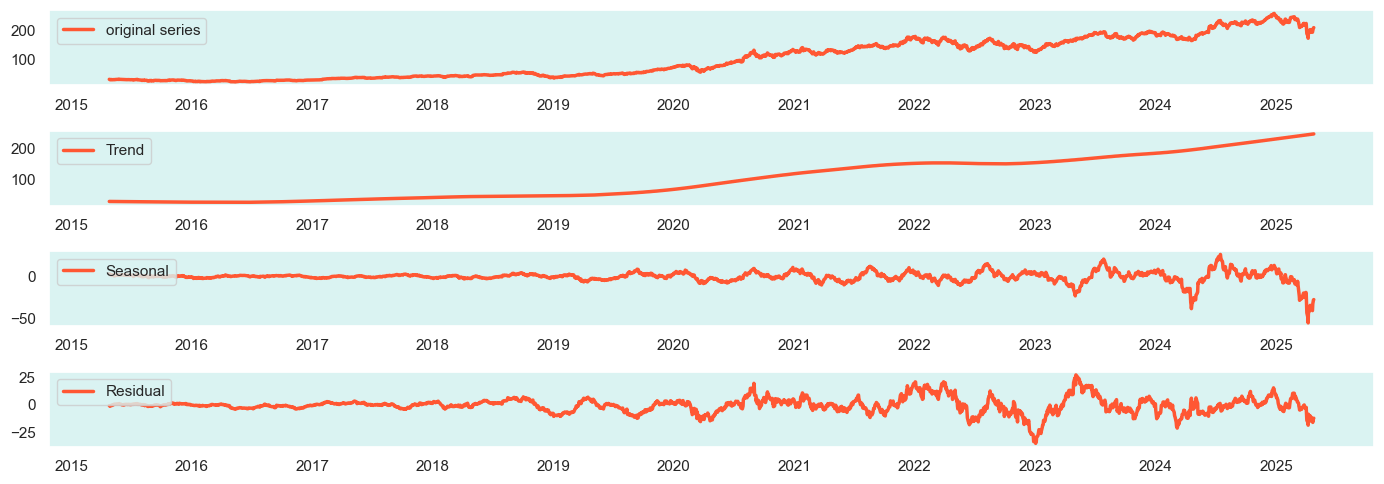

In [239]:
## perfroming stl decompostion   
stl = STL(close_data['AAPL'],period=period_annual)
## fit the data  
results = stl.fit()
## extract the components  
## plotting the plots  
plt.figure(figsize=(14,5))
plt.subplot(4,1,1)
plt.plot(results.observed,label="original series",color="#FF5733",linewidth=2.5)
plt.legend(loc='upper left')
plt.subplot(4,1,2)
plt.plot(results.trend,label="Trend",color="#FF5733",linewidth=2.5)
plt.legend(loc='upper left')
plt.subplot(4,1,3)
plt.plot(results.seasonal,label="Seasonal",color="#FF5733",linewidth=2.5)
plt.legend(loc='upper left')
plt.subplot(4,1,4)
plt.plot(results.resid,label="Residual",color="#FF5733",linewidth=2.5)
plt.legend(loc='upper left')
plt.tight_layout()
plt.subplots_adjust()
plt.show()


### **STATIONARITY TEST**

In [240]:
from statsmodels.tsa.stattools import adfuller,kpss
## perform Augmented Dickey fuller test  
Adf_test = adfuller(close_data['AAPL'])
## print   
print("\nADF TEST RESULTS")
print(f"ADF TEST STASTIC: {round(Adf_test[0],3)}")
print(f"ADF P-VALUE: {round(Adf_test[1],3)}")
print("CRITICAL VALUES")
for key , value in Adf_test[4].items():  
    print(f"{key}:{round(value,3)}")
if Adf_test[1] > 0.05:  
    print("\nThe Series has a Unit Root (Non-Stationary)")
else:
    print("The Seris has no Unit root (Stationary)")


ADF TEST RESULTS
ADF TEST STASTIC: -0.289
ADF P-VALUE: 0.927
CRITICAL VALUES
1%:-3.433
5%:-2.863
10%:-2.567

The Series has a Unit Root (Non-Stationary)


In [241]:
## kpss test  
## perform Augmented Dickey fuller test  
kpss_test = kpss(close_data['AAPL'],regression="ct")
## print   
print("\nADF TEST RESULTS")
print(f"ADF TEST STASTIC: {round(kpss_test[0],3)}")
print(f"ADF P-VALUE: {round(kpss_test[1],3)}")
print("CRITICAL VALUES")
for key , value in kpss_test[3].items():  
    print(f"{key}:{round(value,3)}")
if kpss_test[1] > 0.05:  
    print("\nThe Series has no  Unit Root (Stationary)")
else:
    print("The Seris has a  Unit root (Non-Stationary)")




ADF TEST RESULTS
ADF TEST STASTIC: 1.051
ADF P-VALUE: 0.01
CRITICAL VALUES
10%:0.119
5%:0.146
2.5%:0.176
1%:0.216
The Seris has a  Unit root (Non-Stationary)


##### **WEAK STATIONARITY VS STRONG STATIONARITY**

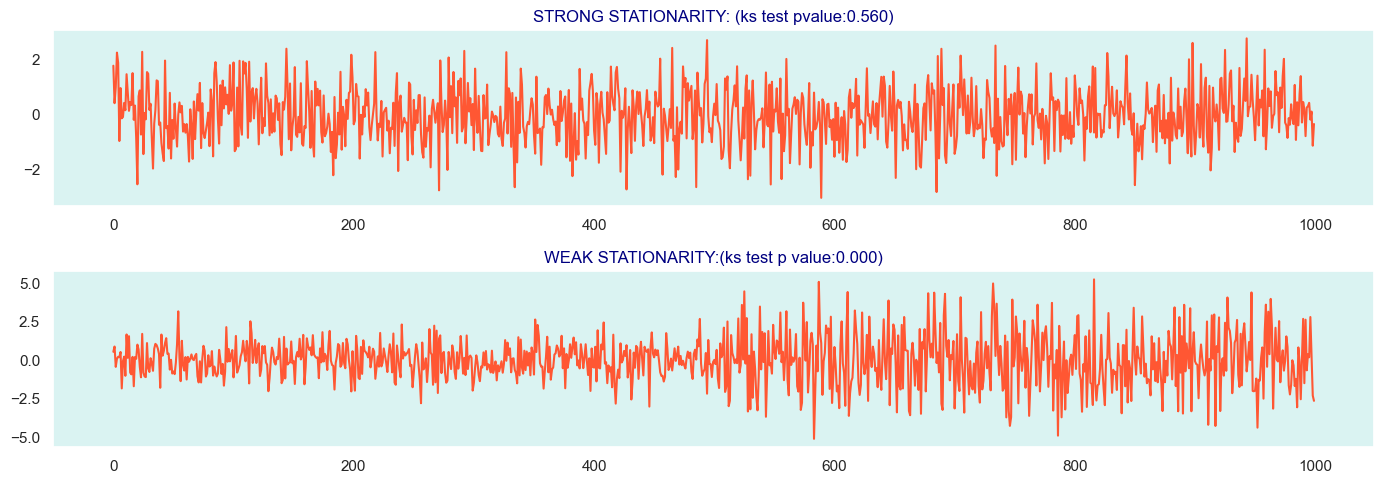

In [242]:
## Generating synthetic data for demonstration 
np.random.seed(0)
## number of samples  
n=1000
##Strictly Stationary Seris:normally distributed Random Noise 
Strictly_stationary_series = np.random.normal(loc=0,scale=1,size=n)
## Non Strictly Stationary Seris Changing Variance
non_striclty_stationary_series = np.concatenate([ 
    np.random.normal(loc=0,scale=1,size=n//2),  
    np.random.normal(loc=0,scale=2,size=n//2), 

])
## function to split the series into 2 haves and perform ks test 
def ks_test_stationarity(series):  
    split = len(series)//2
    series_first_half = series[:split]
    series_second_half = series[split:]
    ## perform ks test   
    stat,pvalue = ks_2samp(series_first_half,series_second_half)
    return stat,pvalue
## Perform KS test on strict stationarity  
ks_stat_strict,ks_pvalue_strict = ks_test_stationarity(Strictly_stationary_series)
## perform ks test on non strictly stationary sereis  
ks_stat_non_strict,ks_pvalue_non_strict = ks_test_stationarity(non_striclty_stationary_series)
## plot the series 
plt.figure(figsize=(14,5))
plt.subplot(2,1,1)
plt.title(f"STRONG STATIONARITY: (ks test pvalue:{ks_pvalue_strict:.3f})",color='navy')
plt.plot(Strictly_stationary_series,color="#FF5733")
plt.subplot(2,1,2)
plt.title(f"WEAK STATIONARITY:(ks test p value:{ks_pvalue_non_strict:.3f})",color='navy')
plt.plot(non_striclty_stationary_series,color="#FF5733")
plt.tight_layout()
plt.show()


### **MAKING THE DATA STATIONARY**

In [243]:
## creating a funcrion to test for stationarity  
def adf_test(series):  
    result = adfuller(series)
    print(f"ADF TEST STAT:{round(result[0],3)}")
    print(f"ADF P VALUE:{round(result[1],3)}")
    print("CRITICAL VALUES")
    for key , value in result[4].items():  
       print(f"{key}:{round(value,3)}")
    if result[1] > 0.05:  
       print("\nThe Series has a Unit Root (Non-Stationary)")
    else:
         print("The Seris has no Unit root (Stationary)")
## checking prices 
prices = close_data['AAPL']
## perform adf test  
adf_test(prices)
    

ADF TEST STAT:-0.289
ADF P VALUE:0.927
CRITICAL VALUES
1%:-3.433
5%:-2.863
10%:-2.567

The Series has a Unit Root (Non-Stationary)


#### **Polynomial detrending**

In [244]:
## polynomial detrending 
## x_coord 
x_cord = np.arange(len(prices))
## coefficients 
trend_coeff_degree_1 = np.polyfit(x=x_cord,y=prices,deg=1)
## calcualting the height  
trendline_degree_1 = np.polyval(trend_coeff_degree_1 , x_cord)
## prices detrended  
prices_detrended_deegree_1 = prices - trendline_degree_1

In [245]:
## ploynomial degree 2  
## polynomial detrending 
## x_coord 
x_cord = np.arange(len(prices))
## coefficients 
trend_coeff_degree_2 = np.polyfit(x=x_cord,y=prices,deg=2)
## calcualting the height  
trendline_degree_2 = np.polyval(trend_coeff_degree_2 , x_cord)
## prices detrended  
prices_detrended_deegree_2 = prices - trendline_degree_2


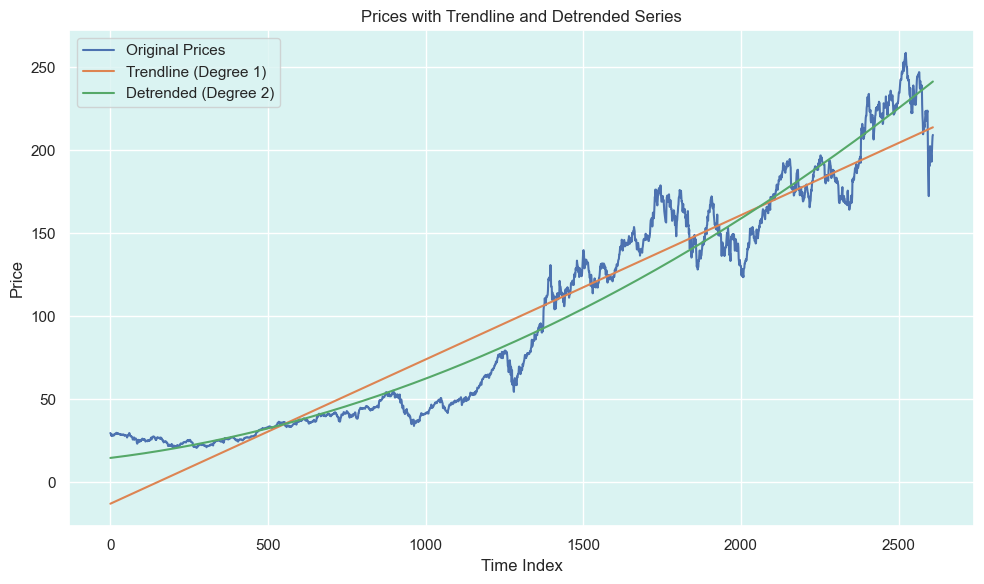

In [246]:
x = np.arange(len(prices))

plt.figure(figsize=(10, 6))
plt.plot(x, prices, label='Original Prices')
plt.plot(x, trendline_degree_1, label='Trendline (Degree 1)')
plt.plot(x, trendline_degree_2, label='Detrended (Degree 2)')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.title('Prices with Trendline and Detrended Series')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [247]:
## stationarity check  
adf_test(prices_detrended_deegree_1)

ADF TEST STAT:-3.017
ADF P VALUE:0.033
CRITICAL VALUES
1%:-3.433
5%:-2.863
10%:-2.567
The Seris has no Unit root (Stationary)


In [248]:
## degree 2 check 
adf_test(prices_detrended_deegree_2)

ADF TEST STAT:-3.083
ADF P VALUE:0.028
CRITICAL VALUES
1%:-3.433
5%:-2.863
10%:-2.567
The Seris has no Unit root (Stationary)


#### **Moving Average detrending**

In [249]:
## Moving Average detrending  
## window  
window = 21
prices_ma = prices.rolling(window=window).mean()
## removing the trend  
prices_detreend_ma = prices - prices_ma
prices_detreend_ma = prices_detreend_ma.dropna()

In [250]:
## checking for stationarity  
adf_test(prices_detreend_ma)

ADF TEST STAT:-9.104
ADF P VALUE:0.0
CRITICAL VALUES
1%:-3.433
5%:-2.863
10%:-2.567
The Seris has no Unit root (Stationary)


### **Decomposition detrending**

In [251]:
## decomposition detrending  
decomposition = seasonal_decompose(prices ,model="additive",period=period_annual)
## priices adjusted  
prices_adjusted = prices/decomposition.seasonal
prices_adjusted = prices_adjusted.dropna()
prices_adjusted_2 = prices/decomposition.trend
prices_adjusted_2 = prices_adjusted_2.dropna()

In [252]:
## checking for stationarity  
adf_test(prices_adjusted)

ADF TEST STAT:-12.683
ADF P VALUE:0.0
CRITICAL VALUES
1%:-3.433
5%:-2.863
10%:-2.567
The Seris has no Unit root (Stationary)


In [253]:
adf_test(prices_adjusted_2)

ADF TEST STAT:-6.435
ADF P VALUE:0.0
CRITICAL VALUES
1%:-3.433
5%:-2.863
10%:-2.567
The Seris has no Unit root (Stationary)


### **Differencing detrending** 

In [254]:
## apllying differencing  
prices.diff()

2015-04-27         NaN
2015-04-28   -0.466755
2015-04-29   -0.428793
2015-04-30   -0.779415
2015-05-01    0.848648
                ...   
2025-04-21   -3.819992
2025-04-22    6.580002
2025-04-23    4.860001
2025-04-24    3.769989
2025-04-25    0.910004
Freq: B, Name: AAPL, Length: 2610, dtype: float64

In [255]:
## differencing  
prices_diff = prices.diff().dropna()
## test for stationarity  
adf_test(prices_diff)

ADF TEST STAT:-16.576
ADF P VALUE:0.0
CRITICAL VALUES
1%:-3.433
5%:-2.863
10%:-2.567
The Seris has no Unit root (Stationary)


#### **TRANSFORMATION  OF THE SERIES**

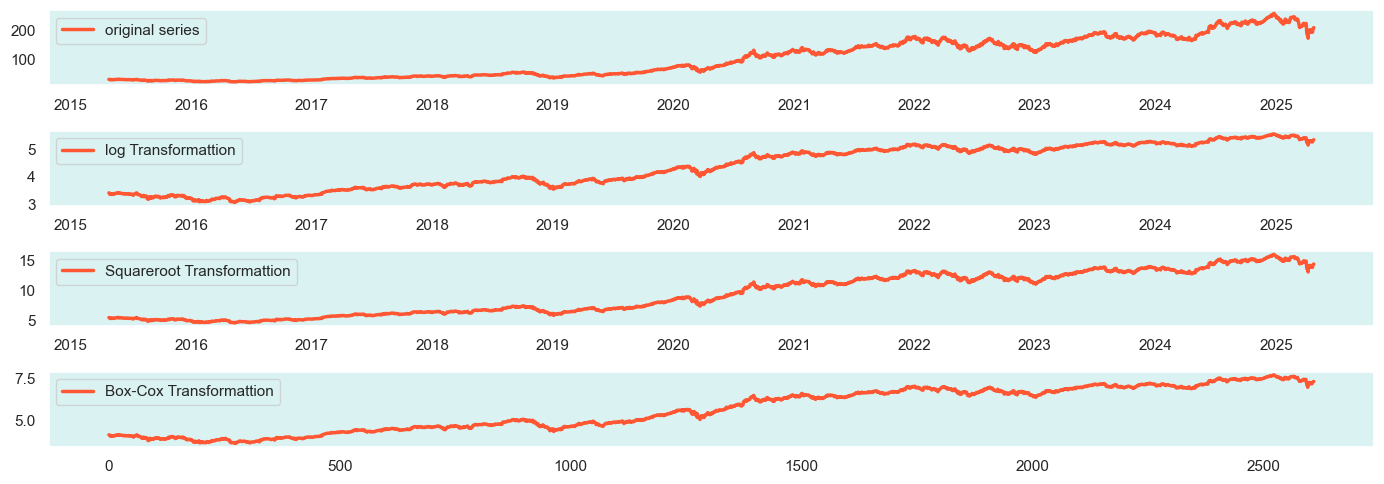

In [256]:
## LOG TRANSFORMATION  
prices_logtransformed = np.log1p(prices)
##  SQUAARE ROOT TRANSFORMATION  
prices_sqrt_transformed = np.sqrt(prices)
## Box-Cox  
prices_Boxcoxed_transformed ,lambda_ = stats.boxcox(prices[prices>0])
## plot  
plt.figure(figsize=(14,5))
plt.subplot(4,1,1)
plt.plot(prices,label='original series',color="#FF5733",linewidth=2.5)
plt.legend(loc='upper left')
plt.subplot(4,1,2)
plt.plot(prices_logtransformed,label='log Transformattion',color="#FF5733",linewidth=2.5)
plt.legend(loc='upper left')
plt.subplot(4,1,3)
plt.plot(prices_sqrt_transformed,label='Squareroot Transformattion',color="#FF5733",linewidth=2.5)
plt.legend(loc='upper left')
plt.subplot(4,1,4)
plt.plot(prices_Boxcoxed_transformed,label='Box-Cox Transformattion',color="#FF5733",linewidth=2.5)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


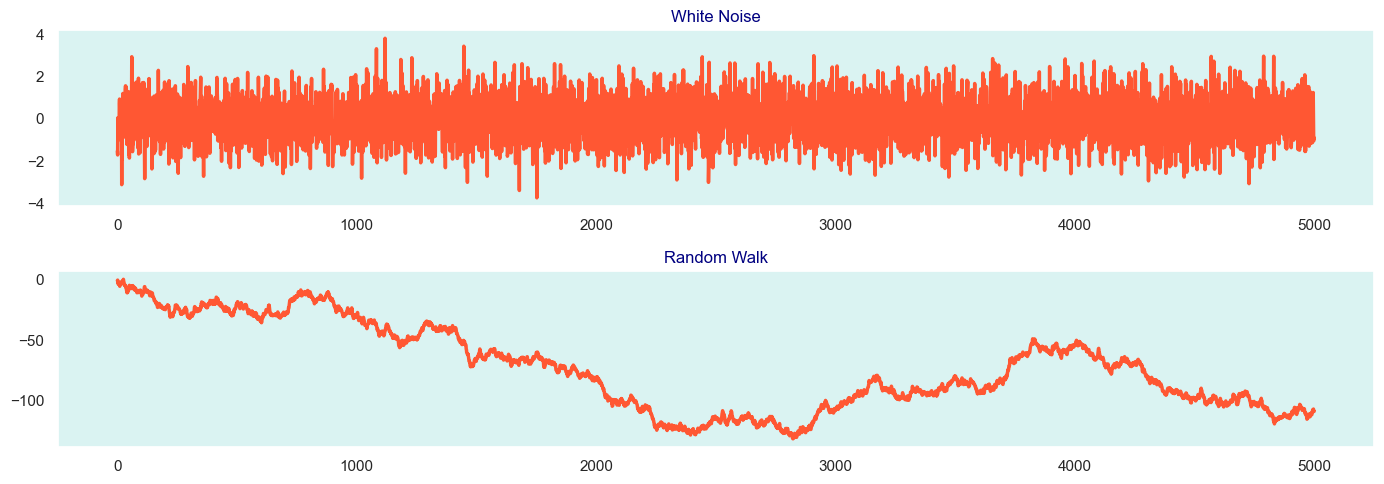


 Ljung test for White Noise
|    |   lb_stat |   lb_pvalue |
|---:|----------:|------------:|
| 40 |   41.0227 |    0.425499 |

 Ljung test for Raandom Walk
|    |   lb_stat |   lb_pvalue |
|---:|----------:|------------:|
| 40 |    193405 |           0 |


In [257]:
## white noise  
white_noise = stats.norm.rvs(loc=0,scale=1,size=5000)
## Random Walk  
random_shocks = stats.norm.rvs(0,1,size=5000)
## random walk  
random_walk = np.cumsum(random_shocks)
## plot  
plt.figure(figsize=(14,5))
plt.subplot(2,1,1)
plt.plot(white_noise,color="#FF5733",linewidth=2.5)
plt.title("White Noise",color='navy')
plt.subplot(2,1,2)
plt.plot(random_walk,color="#FF5733",linewidth=2.5)
plt.title("Random Walk",color='navy')
plt.tight_layout()
plt.show()

print("\n Ljung test for White Noise")
ljung_test_whitenoise= acorr_ljungbox(white_noise,lags=[40],return_df=True)
print(ljung_test_whitenoise.to_markdown())
print("\n Ljung test for Raandom Walk")
ljung_test_randoom_walk= acorr_ljungbox(random_walk,lags=[40],return_df=True)
print(ljung_test_randoom_walk.to_markdown())

### **MODELS**

In [258]:
## import necessary libraries  
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.holtwinters import ExponentialSmoothing,SimpleExpSmoothing
from statsmodels.tsa.api import VAR,VARMAX
from statsmodels.tsa.statespace import varmax
from statsmodels.tsa.exponential_smoothing import ets
from statsmodels.graphics.tsaplots import  plot_acf,plot_pacf
from sklearn.metrics import  mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,root_mean_squared_error,r2_score



#### **ACF AND PACF**

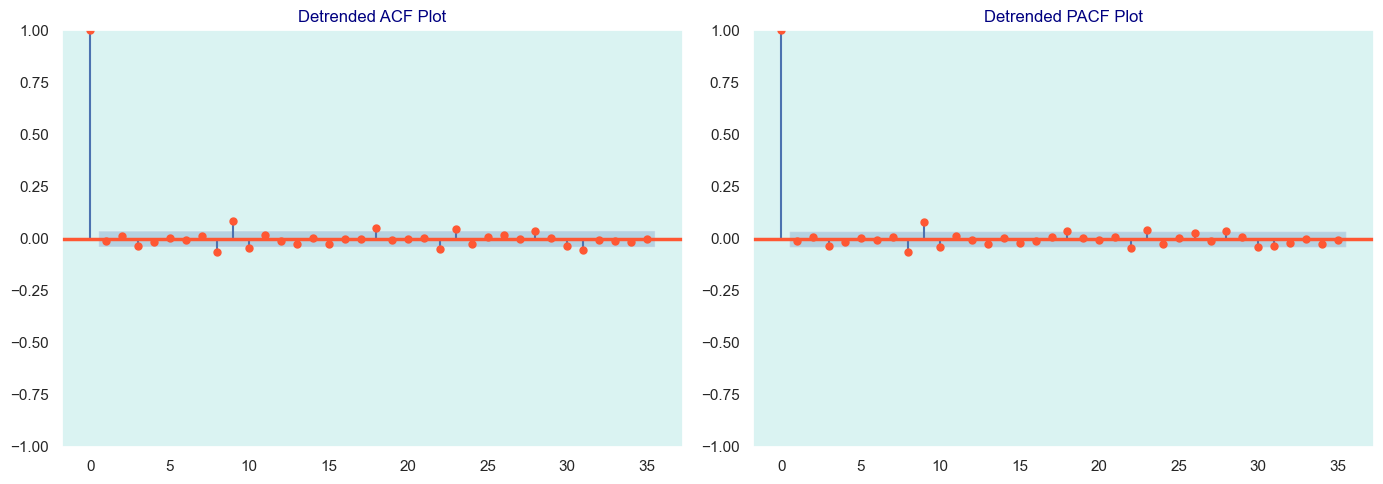

In [259]:
## Detrending the data 
plt.figure(figsize=(14, 5))  

# Left plot - ACF
ax1 = plt.subplot(1, 2, 1) 
plot_acf(prices.diff(periods=1).dropna(), 
         color="#FF5733", 
         linewidth=2.5, 
         ax=ax1)
ax1.set_title("Detrended ACF Plot", color='navy')

# Right plot - PACF
ax2 = plt.subplot(1, 2, 2) 
plot_pacf(prices.diff(periods=1).dropna(), 
          color="#FF5733", 
          linewidth=2.5, 
          ax=ax2)
ax2.set_title("Detrended PACF Plot", color='navy')

plt.tight_layout()
plt.show()

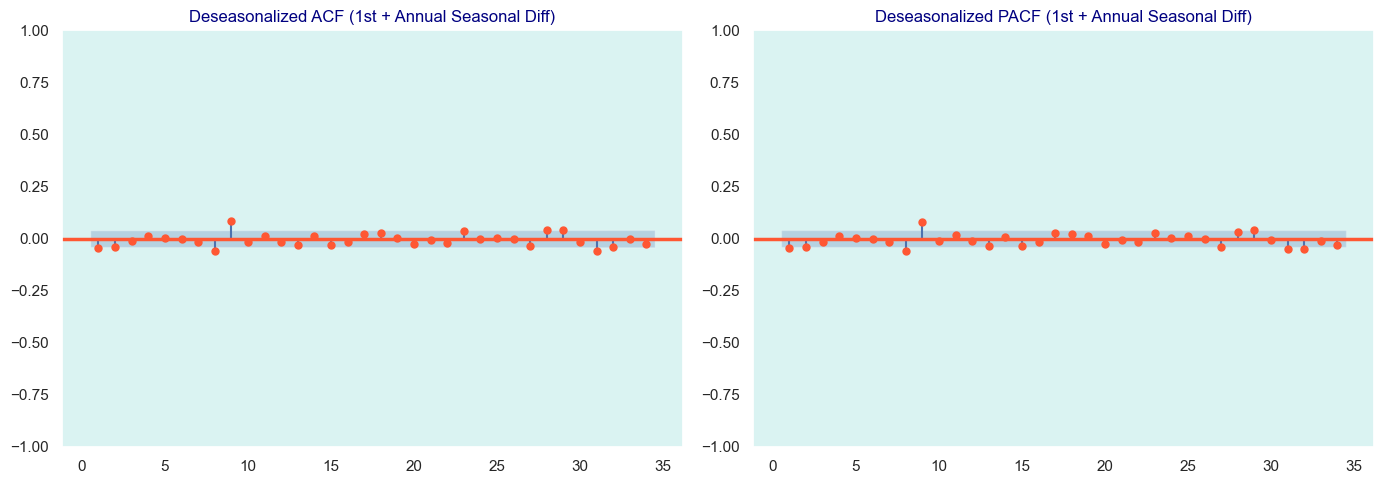

In [260]:
## Deseasonalized plots for Business-Day Data (252-period seasonality)
plt.figure(figsize=(14, 5))

# Left plot - ACF
ax1 = plt.subplot(1, 2, 1)
plot_acf(prices.diff(periods=1).diff(periods=252).dropna(), 
         color="#FF5733", 
         zero=False,
         linewidth=2.5, 
         ax=ax1)
ax1.set_title("Deseasonalized ACF (1st + Annual Seasonal Diff)", color='navy')

# Right plot - PACF
ax2 = plt.subplot(1, 2, 2)
plot_pacf(prices.diff(periods=1).diff(periods=252).dropna(), 
          color="#FF5733", 
          zero=False,
          linewidth=2.5, 
          ax=ax2)
ax2.set_title("Deseasonalized PACF (1st + Annual Seasonal Diff)", color='navy')

plt.tight_layout()
plt.show()

In [261]:
## Y  
y = prices.dropna()
## splitting the data into train and test  
train_size = int(len(y)*0.8)
## train , test  
train ,  test = y.iloc[:train_size],y.iloc[train_size:]
## print the shape of the train size  
train.shape,test.shape


((2088,), (522,))

### **AR MODEL**

In [262]:
## the AR model  
AR = AutoReg(train,lags=1).fit()
## print the summary 
print(AR.summary())

                            AutoReg Model Results                             
Dep. Variable:                   AAPL   No. Observations:                 2088
Model:                     AutoReg(1)   Log Likelihood               -4137.498
Method:               Conditional MLE   S.D. of innovations              1.757
Date:                Sun, 27 Apr 2025   AIC                           8280.996
Time:                        14:01:13   BIC                           8297.926
Sample:                    04-28-2015   HQIC                          8287.199
                         - 04-26-2023                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0706      0.069      1.021      0.307      -0.065       0.206
AAPL.L1        0.9999      0.001   1311.394      0.000       0.998       1.001
                                    Roots           

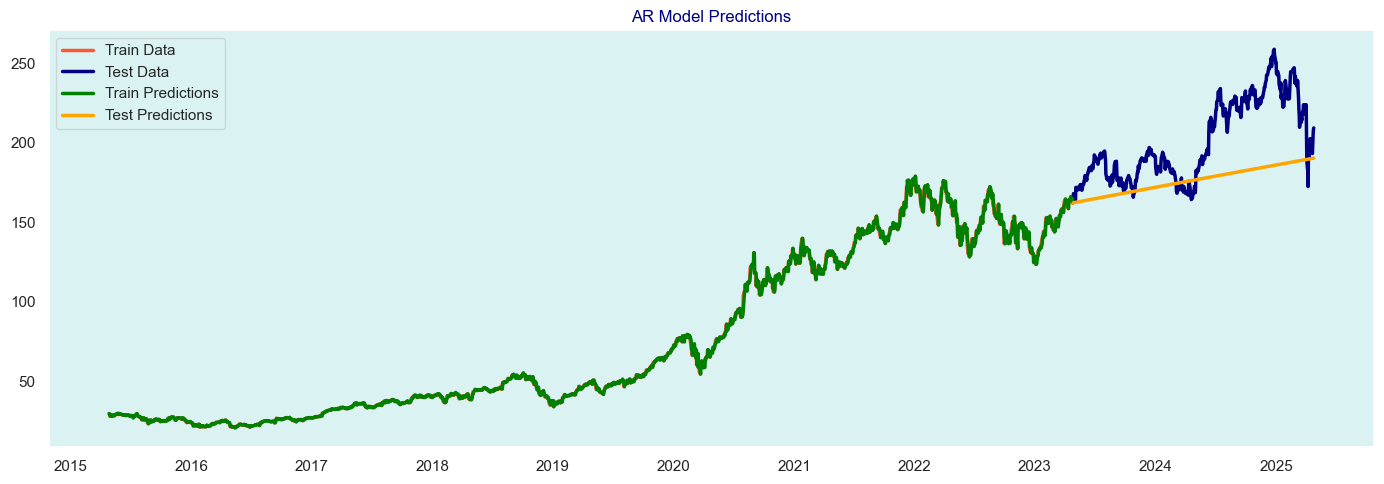

In [263]:
## Make predictions on the train or insample daata first 
predictions_train = AR.predict(start=train.index[0],end=train.index[-1])
## predicyons on the test or out of sample data
predictions_test = AR.predict(start=test.index[0],end=test.index[-1])
## plot the predictions
plt.figure(figsize=(14,5))
plt.plot(train.index,train,color="#FF5733",linewidth=2.5,label="Train Data")
plt.plot(test.index,test,color="navy",linewidth=2.5,label="Test Data")
plt.plot(predictions_train.index,predictions_train,color="green",linewidth=2.5,label="Train Predictions")
plt.plot(predictions_test.index,predictions_test,color="orange",linewidth=2.5,label="Test Predictions")
plt.title("AR Model Predictions",color='navy')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [264]:
## Model Evaluation  
def evaluate_model(y_true,y_pred):  
    mse = mean_squared_error(y_true,y_pred)
    rmse = root_mean_squared_error(y_true,y_pred)
    mae = mean_absolute_error(y_true,y_pred)
    mape = mean_absolute_percentage_error(y_true,y_pred)
    r2 = r2_score(y_true,y_pred)
    return mse,rmse,mae,mape,r2
## Align train and predictions_train by dropping NaN values
aligned_train = train[predictions_train.notna()]
aligned_predictions_train = predictions_train.dropna()

## evaluate the model on the train data
mse_train,rmse_train,mae_train,mape_train,r2_train = evaluate_model(aligned_train, aligned_predictions_train)
print(f"Train MSE: {mse_train:.3f}")
print(f"Train RMSE: {rmse_train:.3f}")
print(f"Train MAE: {mae_train:.3f}")
print(f"Train MAPE: {mape_train:.3f}")
print(f"Train R2: {r2_train:.3f}")
## evaluate the model on the test data
mse_test,rmse_test,mae_test,mape_test,r2_test = evaluate_model(test,predictions_test)
print(f"Test MSE: {mse_test:.3f}")
print(f"Test RMSE: {rmse_test:.3f}")
print(f"Test MAE: {mae_test:.3f}")
print(f"Test MAPE: {mape_test:.3f}")
print(f"Test R2: {r2_test:.3f}")


Train MSE: 3.087
Train RMSE: 1.757
Train MAE: 1.034
Train MAPE: 0.013
Train R2: 0.999
Test MSE: 985.499
Test RMSE: 31.393
Test MAE: 25.543
Test MAPE: 0.118
Test R2: -0.535


#### **ARIMA MODEL**

In [265]:
## ARIMA model
Arima_model = ARIMA(train,order=(1,1,1)).fit()
## print the summary
print(Arima_model.summary())


                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 2088
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4134.277
Date:                Sun, 27 Apr 2025   AIC                           8274.554
Time:                        14:01:16   BIC                           8291.484
Sample:                    04-27-2015   HQIC                          8280.757
                         - 04-26-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3577      0.169      2.117      0.034       0.026       0.689
ma.L1         -0.4197      0.166     -2.528      0.011      -0.745      -0.094
sigma2         3.0775      0.047     66.147      0.0

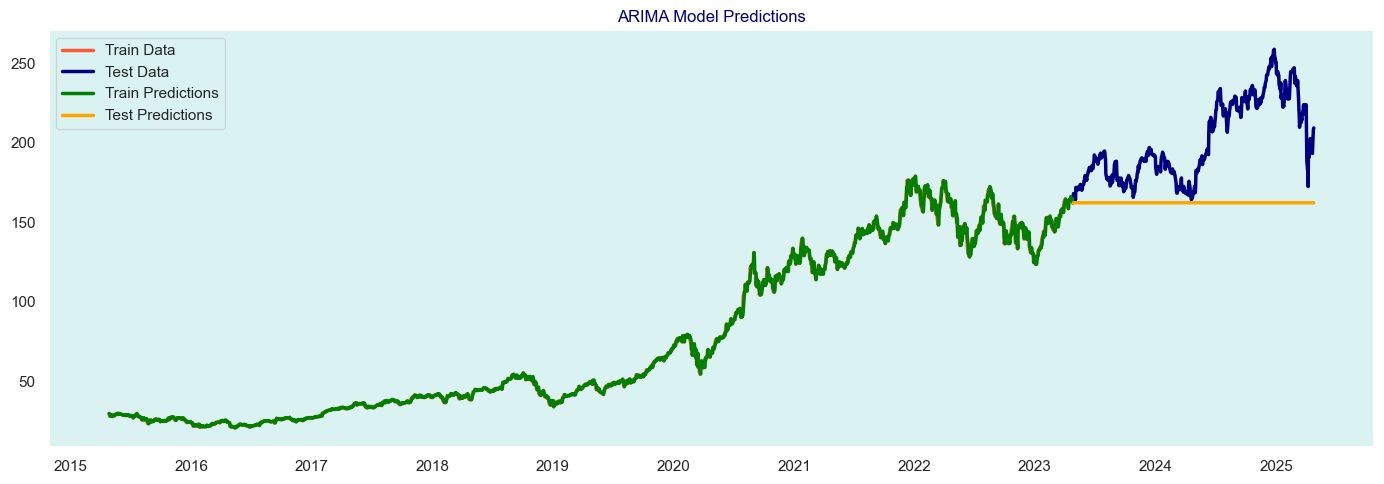

In [266]:
## Make predictions on the test or out of sample data
predictions_test_arima = Arima_model.predict(start=test.index[0],end=test.index[-1])
## plot the predictions
plt.figure(figsize=(14,5))
plt.plot(train.index,train,color="#FF5733",linewidth=2.5,label="Train Data")
plt.plot(test.index,test,color="navy",linewidth=2.5,label="Test Data")
plt.plot(predictions_train.index,predictions_train,color="green",linewidth=2.5,label="Train Predictions")
plt.plot(predictions_test_arima.index,predictions_test_arima,color="orange",linewidth=2.5,label="Test Predictions")
plt.title("ARIMA Model Predictions",color='navy')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [267]:
## Model Evaluation
def evaluate_model(y_true,y_pred):  
    mse = mean_squared_error(y_true,y_pred)
    rmse = root_mean_squared_error(y_true,y_pred)
    mae = mean_absolute_error(y_true,y_pred)
    mape = mean_absolute_percentage_error(y_true,y_pred)
    r2 = r2_score(y_true,y_pred)
    return mse,rmse,mae,mape,r2
## Evaluate on the test data
mse_test_arima,rmse_test_arima,mae_test_arima,mape_test_arima,r2_test_arima = evaluate_model(test,predictions_test_arima)
print(f"Test MSE: {mse_test_arima:.3f}")
print(f"Test RMSE: {rmse_test_arima:.3f}")
print(f"Test MAE: {mae_test_arima:.3f}")
print(f"Test MAPE: {mape_test_arima:.3f}")
print(f"Test R2: {r2_test_arima:.3f}")

Test MSE: 2136.027
Test RMSE: 46.217
Test MAE: 38.651
Test MAPE: 0.180
Test R2: -2.327


### **SARIMAX MODEL**

In [268]:
## Sarima model 
sarima_model = sarimax.SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,1,21)).fit(disp=False)
## print the summary
print(sarima_model.summary())


                                     SARIMAX Results                                      
Dep. Variable:                               AAPL   No. Observations:                 2088
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 21)   Log Likelihood               -4142.324
Date:                            Sun, 27 Apr 2025   AIC                           8294.647
Time:                                    14:02:14   BIC                           8322.814
Sample:                                04-27-2015   HQIC                          8304.973
                                     - 04-26-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3599      0.165      2.186      0.029       0.037       0.683
ma.L1         -0.4232      0.162   

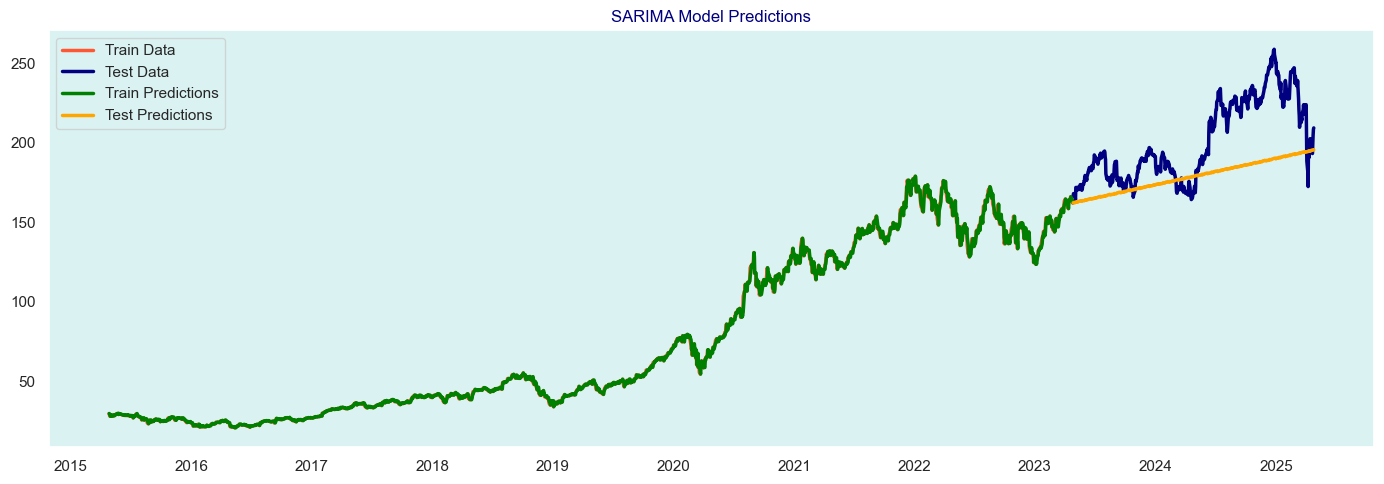

In [269]:
## predictions on the test or out of sample data
predictions_test_sarima = sarima_model.predict(start=test.index[0],end=test.index[-1])
## plot the predictions
plt.figure(figsize=(14,5))
plt.plot(train.index,train,color="#FF5733",linewidth=2.5,label="Train Data")
plt.plot(test.index,test,color="navy",linewidth=2.5,label="Test Data")
plt.plot(predictions_train.index,predictions_train,color="green",linewidth=2.5,label="Train Predictions")
plt.plot(predictions_test_sarima.index,predictions_test_sarima,color="orange",linewidth=2.5,label="Test Predictions")
plt.title("SARIMA Model Predictions",color='navy')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [270]:
### Model Evaluation the test data 
mse_test_sarima,rmse_test_sarima,mae_test_sarima,mape_test_sarima,r2_test_sarima = evaluate_model(test,predictions_test_sarima)
print(f"Test MSE: {mse_test_sarima:.3f}")
print(f"Test RMSE: {rmse_test_sarima:.3f}")
print(f"Test MAE: {mae_test_sarima:.3f}")
print(f"Test MAPE: {mape_test_sarima:.3f}")
print(f"Test R2: {r2_test_sarima:.3f}")

Test MSE: 838.971
Test RMSE: 28.965
Test MAE: 23.560
Test MAPE: 0.109
Test R2: -0.307


### **VAR MODEL**

In [271]:
## Creating a multivariate dataset
# Adding lagged versions of the series as additional variables
train_multivariate = pd.DataFrame({
    'AAPL': train,
    'AAPL_Lag1': train.shift(1),
    'AAPL_Lag2': train.shift(2),
    'AAPL_Lag3': train.shift(3),
    'AAPL_Lag4': train.shift(4)
}).dropna()

# Check for multicollinearity using Variance Inflation Factor (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each column
vif_data = pd.DataFrame()
vif_data["feature"] = train_multivariate.columns
vif_data["VIF"] = [variance_inflation_factor(train_multivariate.values, i) for i in range(train_multivariate.shape[1])]

# Print VIF values
print("Variance Inflation Factor (VIF):")
print(vif_data)

# Drop columns with high VIF (e.g., VIF > 10)
train_multivariate = train_multivariate.drop(columns=['AAPL_Lag4'])  # Example: Drop AAPL_Lag4 if VIF is high

# Fit the VAR model with a maximum of 3 lags (adjusted after removing columns)
var_model = VAR(train_multivariate).fit(maxlags=3, ic='aic')

# Print the summary



Variance Inflation Factor (VIF):
     feature          VIF
0       AAPL  2679.725224
1  AAPL_Lag1  5036.363822
2  AAPL_Lag2  5030.860671
3  AAPL_Lag3  5023.371502
4  AAPL_Lag4  2668.373891


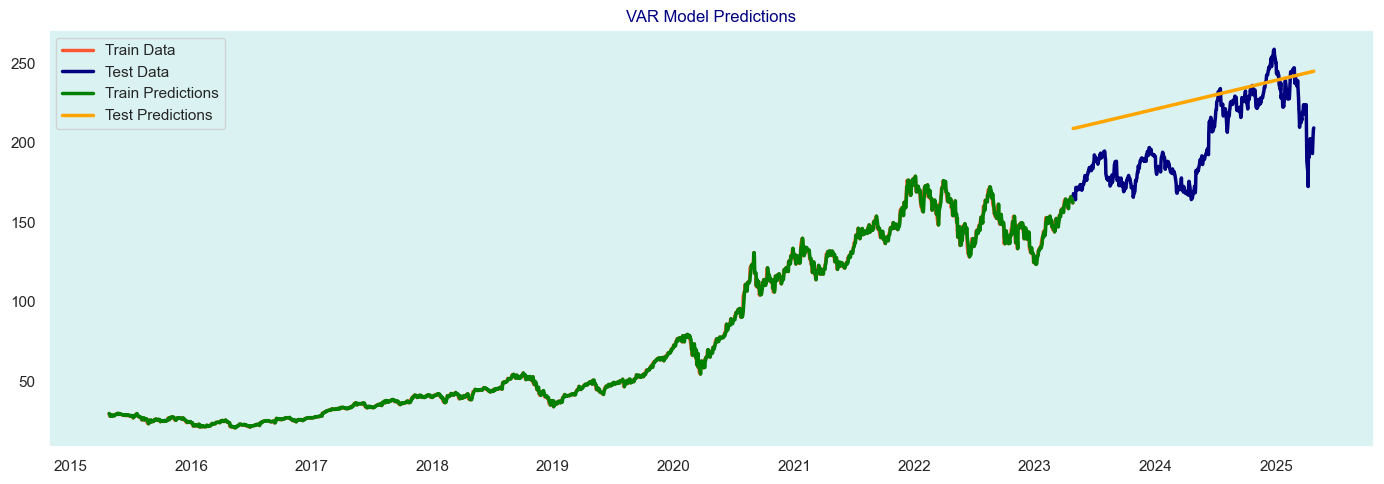

In [272]:
## predictions on the test or out of sample data after making test data multivariate
test_multivariate = pd.DataFrame({
    'AAPL': test,
    'AAPL_Lag1': test.shift(1),
    'AAPL_Lag2': test.shift(2),
    'AAPL_Lag3': test.shift(3),
    'AAPL_Lag4': test.shift(4)
}).dropna()

## Ensure test_multivariate has the same columns as train_multivariate
test_multivariate = test_multivariate.drop(columns=['AAPL_Lag4'])

## predictions on the test or out of sample data
predictions_test_var = var_model.forecast(test_multivariate.values[-var_model.k_ar:], steps=len(test))

## plot the predictions
plt.figure(figsize=(14,5))
plt.plot(train.index,train,color="#FF5733",linewidth=2.5,label="Train Data")
plt.plot(test.index,test,color="navy",linewidth=2.5,label="Test Data")
plt.plot(predictions_train.index,predictions_train,color="green",linewidth=2.5,label="Train Predictions")
plt.plot(test.index,predictions_test_var[:, 0],color="orange",linewidth=2.5,label="Test Predictions")  # Use only the first column for AAPL predictions
plt.title("VAR Model Predictions",color='navy')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### **ETS MODELS**

In [273]:
## ETS (A,A,N) model  
ets_model_AAN = ets.ETSModel(train, seasonal_periods=69, trend='add', seasonal='add', error='add').fit(disp=False)
## print the summary
print(ets_model_AAN.summary())

                                 ETS Results                                  
Dep. Variable:                   AAPL   No. Observations:                 2088
Model:                       ETS(AAA)   Log Likelihood               -4102.800
Date:                Sun, 27 Apr 2025   AIC                           8355.601
Time:                        14:02:41   BIC                           8778.898
Sample:                    04-27-2015   HQIC                          8510.688
                         - 04-26-2023   Scale                            2.980
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9439      0.022     42.166      0.000       0.900       0.988
smoothing_trend      9.439e-05        nan        nan        nan         nan         nan
smoothing_season

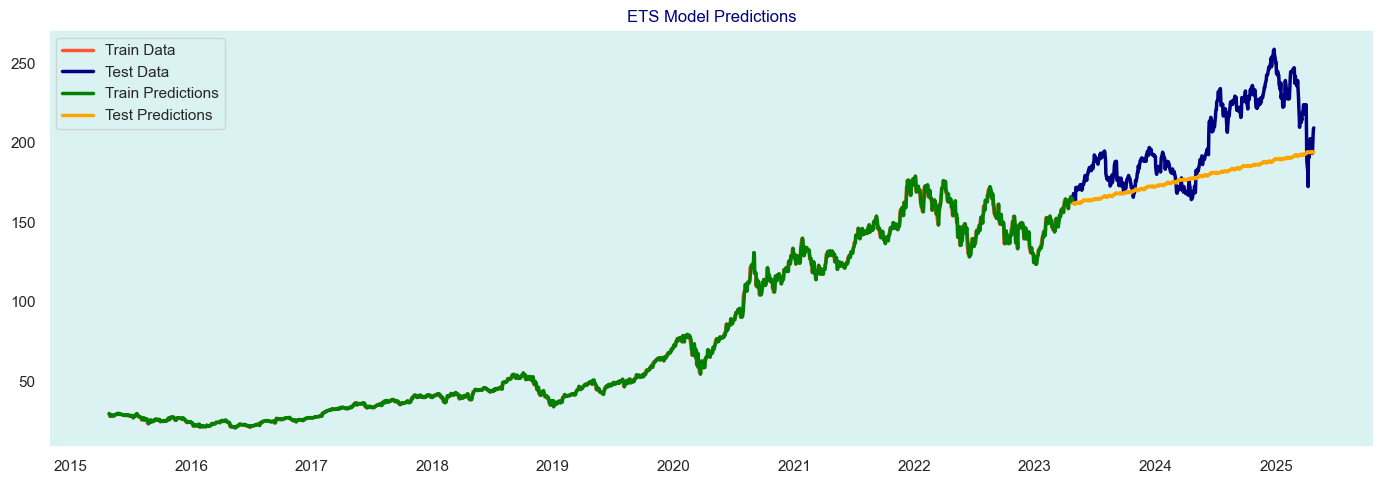

In [274]:
## making predictions on the test or out of sample data
predictions_test_ets_AAN = ets_model_AAN.forecast(steps=len(test))
## plot the predictions
plt.figure(figsize=(14,5))
plt.plot(train.index,train,color="#FF5733",linewidth=2.5,label="Train Data")
plt.plot(test.index,test,color="navy",linewidth=2.5,label="Test Data")
plt.plot(predictions_train.index,predictions_train,color="green",linewidth=2.5,label="Train Predictions")
plt.plot(test.index,predictions_test_ets_AAN,color="orange",linewidth=2.5,label="Test Predictions")
plt.title("ETS Model Predictions",color='navy')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [275]:
## Model Evaluation the test data
mse_test_ets_AAN,rmse_test_ets_AAN,mae_test_ets_AAN,mape_test_ets_AAN,r2_test_ets_AAN = evaluate_model(test,predictions_test_ets_AAN)
print(f"Test MSE: {mse_test_ets_AAN:.3f}")
print(f"Test RMSE: {rmse_test_ets_AAN:.3f}")
print(f"Test MAE: {mae_test_ets_AAN:.3f}")
print(f"Test MAPE: {mape_test_ets_AAN:.3f}")
print(f"Test R2: {r2_test_ets_AAN:.3f}")


Test MSE: 883.415
Test RMSE: 29.722
Test MAE: 24.288
Test MAPE: 0.113
Test R2: -0.376


In [276]:
## ETS(A,A,M) model
ets_model_AAM = ets.ETSModel(train, seasonal_periods=69, trend='add', seasonal='add', error='multiplicative').fit(disp=False)
## print the summary
print(ets_model_AAM.summary())

                                 ETS Results                                  
Dep. Variable:                   AAPL   No. Observations:                 2088
Model:                       ETS(MAA)   Log Likelihood               -3131.003
Date:                Sun, 27 Apr 2025   AIC                           6412.006
Time:                        14:03:11   BIC                           6835.303
Sample:                    04-27-2015   HQIC                          6567.093
                         - 04-26-2023   Scale                            0.000
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9166      0.022     41.025      0.000       0.873       0.960
smoothing_trend         0.0013      0.002      0.859      0.390      -0.002       0.004
smoothing_season

In [277]:
## Mode Evaluation the test data
mse_test_ets_AAM,rmse_test_ets_AAM,mae_test_ets_AAM,mape_test_ets_AAM,r2_test_ets_AAM = evaluate_model(test,predictions_test_ets_AAN)
print(f"Test MSE: {mse_test_ets_AAM:.3f}")
print(f"Test RMSE: {rmse_test_ets_AAM:.3f}")
print(f"Test MAE: {mae_test_ets_AAM:.3f}")
print(f"Test MAPE: {mape_test_ets_AAM:.3f}")
print(f"Test R2: {r2_test_ets_AAM:.3f}")

Test MSE: 883.415
Test RMSE: 29.722
Test MAE: 24.288
Test MAPE: 0.113
Test R2: -0.376


In [278]:
## One with Multiplicative error and multiplicative seasonal component
ets_model_MAM= ets.ETSModel(train, seasonal_periods=69, trend='add', seasonal='mul', error='multiplicative').fit(disp=False)
## print the summary
print(ets_model_MAM.summary())


                                 ETS Results                                  
Dep. Variable:                   AAPL   No. Observations:                 2088
Model:                       ETS(MAM)   Log Likelihood               -3123.886
Date:                Sun, 27 Apr 2025   AIC                           6397.773
Time:                        14:03:44   BIC                           6821.070
Sample:                    04-27-2015   HQIC                          6552.860
                         - 04-26-2023   Scale                            0.000
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9164      0.022     42.496      0.000       0.874       0.959
smoothing_trend         0.0013      0.002      0.838      0.402      -0.002       0.004
smoothing_season

In [279]:
## Model Evaluation the test data
mse_test_ets_AAN,rmse_test_ets_AAN,mae_test_ets_AAN,mape_test_ets_AAN,r2_test_ets_AAN = evaluate_model(test,predictions_test_ets_AAN)
print(f"Test MSE: {mse_test_ets_AAN:.3f}")
print(f"Test RMSE: {rmse_test_ets_AAN:.3f}")
print(f"Test MAE: {mae_test_ets_AAN:.3f}")
print(f"Test MAPE: {mape_test_ets_AAN:.3f}")
print(f"Test R2: {r2_test_ets_AAN:.3f}")


Test MSE: 883.415
Test RMSE: 29.722
Test MAE: 24.288
Test MAPE: 0.113
Test R2: -0.376


In [280]:
## Holt Winters Exponential Smoothing (HWES) model with multiplicative seasonal component
hwes_model = ExponentialSmoothing(train, seasonal_periods=69, trend='add', seasonal='mul').fit()
## print the summary
print(hwes_model.summary())


                       ExponentialSmoothing Model Results                       
Dep. Variable:                     AAPL   No. Observations:                 2088
Model:             ExponentialSmoothing   SSE                           5955.602
Optimized:                         True   AIC                           2334.486
Trend:                         Additive   BIC                           2746.495
Seasonal:                Multiplicative   AICC                          2340.152
Seasonal Periods:                    69   Date:                 Sun, 27 Apr 2025
Box-Cox:                          False   Time:                         14:03:47
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9490575                alpha                 True
smoothing_trend          

In [281]:
## Model Evaluation the test data
mse_test_ets_AAN,rmse_test_ets_AAN,mae_test_ets_AAN,mape_test_ets_AAN,r2_test_ets_AAN = evaluate_model(test,predictions_test_ets_AAN)
print(f"Test MSE: {mse_test_ets_AAN:.3f}")
print(f"Test RMSE: {rmse_test_ets_AAN:.3f}")
print(f"Test MAE: {mae_test_ets_AAN:.3f}")
print(f"Test MAPE: {mape_test_ets_AAN:.3f}")    
print(f"Test R2: {r2_test_ets_AAN:.3f}")

Test MSE: 883.415
Test RMSE: 29.722
Test MAE: 24.288
Test MAPE: 0.113
Test R2: -0.376


### **GRANGER CASUALITY TEST**

In [282]:
## Granger Casualityy Test  
from statsmodels.tsa.stattools import  grangercausalitytests

In [283]:
## Telsa data  
Telsa_data = stock("TSLA")

[*********************100%***********************]  1 of 1 completed


In [284]:
## checking the data  
Telsa_data.head()

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2015-04-27,15.436667,15.916667,14.800000,14.837333,175089000
2015-04-28,15.365333,15.700000,15.202000,15.650000,91281000
2015-04-29,15.496667,15.664667,15.175333,15.336667,59041500
2015-04-30,15.070000,15.526000,15.011333,15.359333,58678500
2015-05-01,15.068667,15.451333,14.694000,15.329333,79225500


In [285]:
Telsa_data.index = pd.to_datetime(Telsa_data.index).to_period(freq='B')
Telsa_data.index

PeriodIndex(['2015-04-27', '2015-04-28', '2015-04-29', '2015-04-30',
             '2015-05-01', '2015-05-04', '2015-05-05', '2015-05-06',
             '2015-05-07', '2015-05-08',
             ...
             '2025-04-11', '2025-04-14', '2025-04-15', '2025-04-16',
             '2025-04-17', '2025-04-21', '2025-04-22', '2025-04-23',
             '2025-04-24', '2025-04-25'],
            dtype='period[B]', name='Date', length=2516)

In [286]:
## idx 
idx = pd.period_range(min(Telsa_data.index),max(Telsa_data.index))
idx

PeriodIndex(['2015-04-27', '2015-04-28', '2015-04-29', '2015-04-30',
             '2015-05-01', '2015-05-04', '2015-05-05', '2015-05-06',
             '2015-05-07', '2015-05-08',
             ...
             '2025-04-14', '2025-04-15', '2025-04-16', '2025-04-17',
             '2025-04-18', '2025-04-21', '2025-04-22', '2025-04-23',
             '2025-04-24', '2025-04-25'],
            dtype='period[B]', length=2610)

In [287]:
Telsa_data.index.symmetric_difference(idx)

PeriodIndex(['2015-05-25', '2015-07-03', '2015-09-07', '2015-11-26',
             '2015-12-25', '2016-01-01', '2016-01-18', '2016-02-15',
             '2016-03-25', '2016-05-30', '2016-07-04', '2016-09-05',
             '2016-11-24', '2016-12-26', '2017-01-02', '2017-01-16',
             '2017-02-20', '2017-04-14', '2017-05-29', '2017-07-04',
             '2017-09-04', '2017-11-23', '2017-12-25', '2018-01-01',
             '2018-01-15', '2018-02-19', '2018-03-30', '2018-05-28',
             '2018-07-04', '2018-09-03', '2018-11-22', '2018-12-05',
             '2018-12-25', '2019-01-01', '2019-01-21', '2019-02-18',
             '2019-04-19', '2019-05-27', '2019-07-04', '2019-09-02',
             '2019-11-28', '2019-12-25', '2020-01-01', '2020-01-20',
             '2020-02-17', '2020-04-10', '2020-05-25', '2020-07-03',
             '2020-09-07', '2020-11-26', '2020-12-25', '2021-01-01',
             '2021-01-18', '2021-02-15', '2021-04-02', '2021-05-31',
             '2021-07-05', '2021-0

In [288]:
### reindexing
Telsa_data = Telsa_data.reindex(idx,fill_value=np.nan)
## forward filling
Telsa_data = Telsa_data.fillna(method="ffill")
Telsa_data.tail()

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
2025-04-21,227.500000,232.210007,222.789993,230.259995,97768000.0
2025-04-22,237.970001,242.789993,229.850006,230.960007,120858500.0
2025-04-23,250.740005,259.450012,244.429993,254.860001,150381900.0
2025-04-24,259.510010,259.540009,249.199997,250.500000,94464200.0
2025-04-25,284.950012,286.850006,259.630005,261.690002,167059300.0


In [289]:
## choosing TSLA CLOSE data  
Telsa_close_data = Telsa_data['Close'][['TSLA']]
## showing the data
Telsa_close_data.head()
## changing the index to timestamp
Telsa_close_data.index = Telsa_close_data.index.to_timestamp()
## checking the index
Telsa_close_data.index

DatetimeIndex(['2015-04-27', '2015-04-28', '2015-04-29', '2015-04-30',
               '2015-05-01', '2015-05-04', '2015-05-05', '2015-05-06',
               '2015-05-07', '2015-05-08',
               ...
               '2025-04-14', '2025-04-15', '2025-04-16', '2025-04-17',
               '2025-04-18', '2025-04-21', '2025-04-22', '2025-04-23',
               '2025-04-24', '2025-04-25'],
              dtype='datetime64[ns]', length=2610, freq='B')

In [290]:
## Making dataframe for Telsa and Apple data aand also differencing the data
Telsa_apple_data = pd.DataFrame({
    'AAPL': prices.diff(periods=1).dropna(),
    'TSLA': Telsa_close_data['TSLA'].diff(periods=1).dropna()
}).dropna()
## checking the data
Telsa_apple_data.head()


,AAPL,TSLA
2015-04-28,-0.466755,-0.071335
2015-04-29,-0.428793,0.131334
2015-04-30,-0.779415,-0.426667
2015-05-01,0.848648,-0.001332
2015-05-04,-0.055836,0.298666


In [291]:
## Adt test  
adf_test(Telsa_apple_data['AAPL'])

ADF TEST STAT:-16.576
ADF P VALUE:0.0
CRITICAL VALUES
1%:-3.433
5%:-2.863
10%:-2.567
The Seris has no Unit root (Stationary)


In [292]:
## adt test for telsa
adf_test(Telsa_apple_data['TSLA'])

ADF TEST STAT:-8.937
ADF P VALUE:0.0
CRITICAL VALUES
1%:-3.433
5%:-2.863
10%:-2.567
The Seris has no Unit root (Stationary)


In [293]:
## Performing Granger Causality test
granger_test = grangercausalitytests(Telsa_apple_data[['AAPL','TSLA']],maxlag=5,verbose=False)
## Extracting the p-values from the test results
p_values = [round(granger_test[i][0]['ssr_ftest'][1], 4) for i in range(1, 6)]
## Creating a DataFrame to display the results
granger_results = pd.DataFrame({
    'Lag': range(1, 6),
    'p-value': p_values
})
## Displaying the results
print(granger_results.to_markdown(index=False))



|   Lag |   p-value |
|------:|----------:|
|     1 |    0.098  |
|     2 |    0.2269 |
|     3 |    0.1765 |
|     4 |    0.2878 |
|     5 |    0.4165 |


In [294]:
## reverse Granger causality test
granger_test_reverse = grangercausalitytests(Telsa_apple_data[['TSLA','AAPL']],maxlag=5,verbose=False)
## Extracting the p-values from the test results
p_values_reverse = [round(granger_test_reverse[i][0]['ssr_ftest'][1], 4) for i in range(1, 6)]
## Creating a DataFrame to display the results
granger_results_reverse = pd.DataFrame({
    'Lag': range(1, 6),
    'p-value': p_values_reverse
})
## Displaying the results
print(granger_results_reverse.to_markdown(index=False))


|   Lag |   p-value |
|------:|----------:|
|     1 |    0.4157 |
|     2 |    0.237  |
|     3 |    0.2861 |
|     4 |    0.4329 |
|     5 |    0.5637 |


### **SMOTTING METHODS**

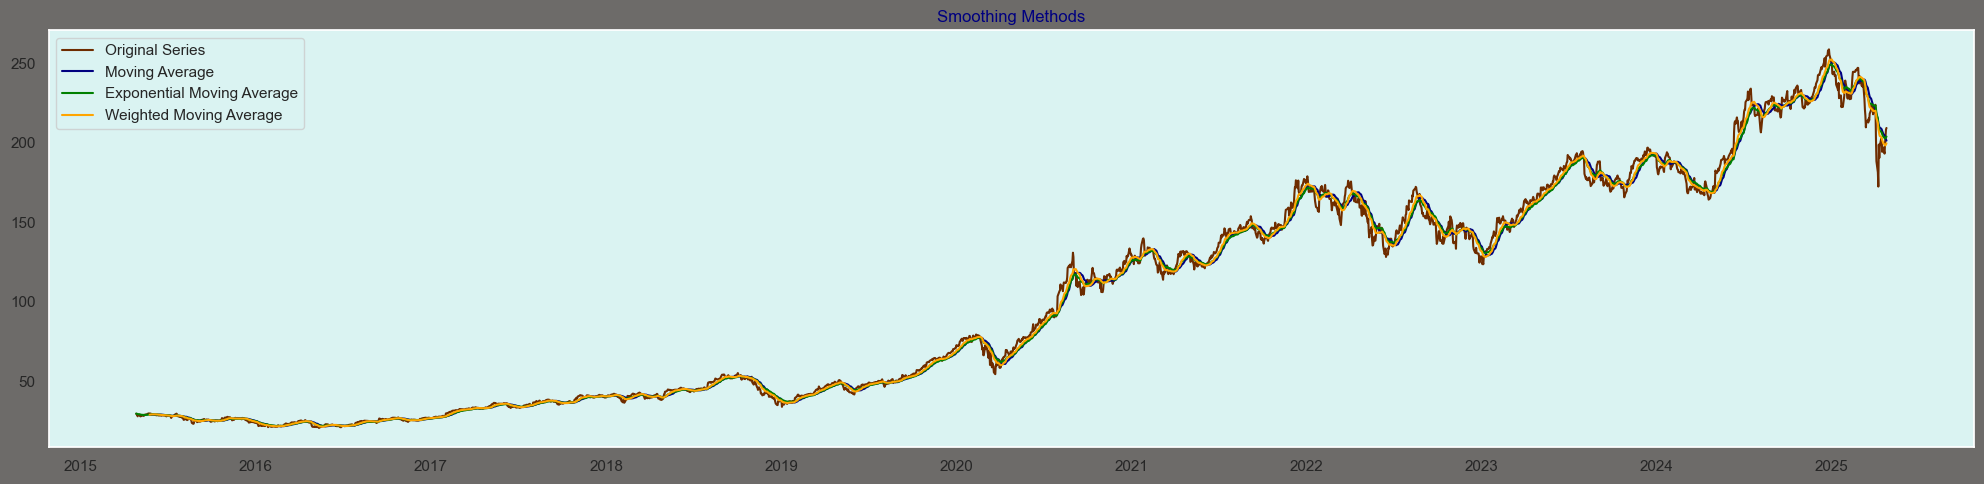

In [295]:
## Smothing Methods 
## MA method  
windoows = 21 
## moving average
moving_average = prices.rolling(window=windoows).mean()
## Exponential moving average
exponential_moving_average = prices.ewm(span=windoows,adjust=False).mean()
## WMA
weights = np.arange(1, windoows + 1)
weighted_moving_average = prices.rolling(window=windoows).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)
## plot the data in one plot
plt.figure(figsize=(20,5),facecolor="#6D6B69")
plt.plot(prices,color="#6E2C00",linewidth=1.5,label="Original Series")
plt.plot(moving_average,color="navy",linewidth=1.5,label="Moving Average")
plt.plot(exponential_moving_average,color="green",linewidth=1.5,label="Exponential Moving Average")
plt.plot(weighted_moving_average,color="orange",linewidth=1.5,label="Weighted Moving Average")
plt.title("Smoothing Methods",color='navy')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


### **DATA-PREPROCESSING**

In [296]:
## data preprocessing    
data = pd.DataFrame({ 
    "Date":["2025-01-01","2025-01-02","2025-01-03","2025-01-04","2025-01-05","2025-01-06","2025-01-07","2025-01-08","2025-01-09","2025-01-10","2025-01-11","2025-01-12", 
            "2025-01-14","2025-01-16","2025-01-18","2025-01-20","2025-01-22","2025-01-24"], 
    "Prices":[100,200,101,1003,106,105,108,100,400,600,700,900,100,1000,200,450,900,200]
})

## set the date as index  
data.set_index("Date",inplace=True)

## 
data.index = pd.to_datetime(data.index)


In [297]:
## creating the complete index    
complete_index = pd.date_range(start="2025-01-01",end="2025-01-24",freq='D')
## reindexing the data  
data = data.reindex(complete_index,fill_value=np.nan)
### check the data  
data.head()

,Prices
2025-01-01,100.0
2025-01-02,200.0
2025-01-03,101.0
2025-01-04,1003.0
2025-01-05,106.0


In [298]:
## checking for missing values  
data.isnull().sum()

Prices    6
dtype: int64

### **Interplotation Methods**

In [299]:
## Linear Interplolation  
data_linear_interpolation = data.interpolate(method="linear")
## Polynomail degree of 2  
data_ploynomial_method = data.interpolate(method="polynomial",order=2)
## spline interplotation 
data_spline_interpolation = data.interpolate(method="spline",order=2)
## print  
print("\n Linear Interpolation",data_linear_interpolation)
print("\n polynomial Interpolation",data_ploynomial_method)
print("\n Spline Interpolation",data_spline_interpolation)


 Linear Interpolation             Prices
2025-01-01   100.0
2025-01-02   200.0
2025-01-03   101.0
2025-01-04  1003.0
2025-01-05   106.0
2025-01-06   105.0
2025-01-07   108.0
2025-01-08   100.0
2025-01-09   400.0
2025-01-10   600.0
2025-01-11   700.0
2025-01-12   900.0
2025-01-13   500.0
2025-01-14   100.0
2025-01-15   550.0
2025-01-16  1000.0
2025-01-17   600.0
2025-01-18   200.0
2025-01-19   325.0
2025-01-20   450.0
2025-01-21   675.0
2025-01-22   900.0
2025-01-23   550.0
2025-01-24   200.0

 polynomial Interpolation                  Prices
2025-01-01   100.000000
2025-01-02   200.000000
2025-01-03   101.000000
2025-01-04  1003.000000
2025-01-05   106.000000
2025-01-06   105.000000
2025-01-07   108.000000
2025-01-08   100.000000
2025-01-09   400.000000
2025-01-10   600.000000
2025-01-11   700.000000
2025-01-12   900.000000
2025-01-13   481.428816
2025-01-14   100.000000
2025-01-15   540.206831
2025-01-16  1000.000000
2025-01-17   677.330197
2025-01-18   200.000000
2025-01-19   195.81